Bee Colony Algorithm


In [ ]:
import numpy as np
import random
from scipy.integrate import odeint
# Example FOPTD model
def system_model(y, t, Kp, Ki, Kd, u):
    tau_p = 5.0  # process time constant
    K_process = 1.0  # process gain
    # Simulate derivative control
    dydt = (-y + K_process * u) / tau_p
    return dydt

def pid_controller(t, setpoint, y, integral_prev, error_prev, Kp, Ki, Kd):
    error = setpoint - y
    integral = integral_prev + error * t
    derivative = (error - error_prev) / t
    u = Kp * error + Ki * integral + Kd * derivative
    return u, integral, error

def simulate_pid(Kp, Ki, Kd, setpoint=1.0, t_final=50):
    t = np.linspace(0, t_final, num=int(t_final*10))
    y = np.zeros(t.shape)
    u = 0
    integral = 0
    error = 0
    for i in range(1, len(t)):
        u, integral, error = pid_controller(t[i]-t[i-1], setpoint, y[i-1], integral, error, Kp, Ki, Kd)
        y[i] = odeint(system_model, y[i-1], [t[i-1], t[i]], args=(Kp, Ki, Kd, u))[-1]
    return t, y

def objective_function(params):
    Kp, Ki, Kd = params
    t, y = simulate_pid(Kp, Ki, Kd)
    setpoint = 1.0
    error = setpoint - y
    return np.sum(np.square(error))  # Integral of Square Error (ISE)

def abc_algorithm(obj_func, param_bounds, colony_size=20, max_iter=100, employed_bees_ratio=0.5):
    dim = len(param_bounds)
    lower_bounds, upper_bounds = zip(*param_bounds)
    population = [np.random.uniform(low=lower_bounds, high=upper_bounds, size=dim) for _ in range(colony_size)]
    fitness = np.array([obj_func(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]

    for _ in range(max_iter):
        # Employed bee phase
        for i in range(colony_size):
            candidate = np.copy(population[i])
            j = np.random.randint(dim)
            partner = np.random.randint(colony_size)
            candidate[j] = population[i][j] + random.uniform(-1, 1) * (population[i][j] - population[partner][j])
            candidate[j] = np.clip(candidate[j], lower_bounds[j], upper_bounds[j])
            candidate_fitness = obj_func(candidate)
            if candidate_fitness < fitness[i]:
                population[i] = candidate
                fitness[i] = candidate_fitness

        # Onlooker bee phase
        fitness_prob = fitness / np.sum(fitness)
        for i in range(colony_size):
            if random.random() < fitness_prob[i]:
                candidate = np.copy(population[i])
                j = np.random.randint(dim)
                partner = np.random.randint(colony_size)
                candidate[j] = population[i][j] + random.uniform(-1, 1) * (population[i][j] - population[partner][j])
                candidate[j] = np.clip(candidate[j], lower_bounds[j], upper_bounds[j])
                candidate_fitness = obj_func(candidate)
                if candidate_fitness < fitness[i]:
                    population[i] = candidate

                    fitness[i] = candidate_fitness
                    if candidate_fitness < fitness[best_idx]:
                        best_idx = i
                        best_solution = candidate

        # Scout bee phase
        # If a solution cannot be improved further, replace it with a new random solution
        limit = 100  # typically a predefined limit
        for i in range(colony_size):
            if fitness[i] > limit:
                new_solution = np.random.uniform(low=lower_bounds, high=upper_bounds, size=dim)
                fitness[i] = obj_func(new_solution)
                population[i] = new_solution
                if fitness[i] < fitness[best_idx]:
                    best_idx = i
                    best_solution = population[i]

    return best_solution, fitness[best_idx]
# Example parameter bounds: [(Kp_min, Kp_max), (Ki_min, Ki_max), (Kd_min, Kd_max)]
param_bounds = [(0.1, 10.0), (0.01, 1.0), (0.01, 1.0)]

# Run the algorithm
best_params, best_fitness = abc_algorithm(objective_function, param_bounds)
print("Best Parameters (Kp, Ki, Kd):", best_params)
print("Best Fitness (Lower is better):", best_fitness)

<ipython-input-41-76e4b46acb1f>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = odeint(system_model, y[i-1], [t[i-1], t[i]], args=(Kp, Ki, Kd, u))[-1]


Best Parameters (Kp, Ki, Kd): [9.71519751 0.92067733 0.24452463]
Best Fitness (Lower is better): 2.621047004817868


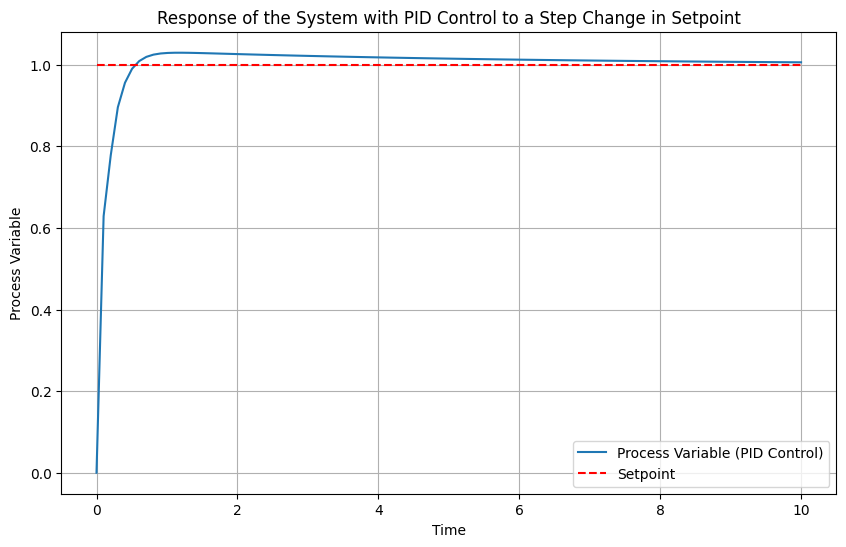

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated system (a simple first-order system)
def model(y, K, dt):
    return y + dt * (-K * (y - 1))

# PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.prev_error = 0
        self.integral = 0

    def control(self, setpoint, process_variable):
        error = setpoint - process_variable
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        control_output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return control_output

# Function to simulate the system with PID control
def simulate_system_with_pid_control(controller, K, setpoint, initial_state, time):
    process_variable = np.zeros(len(time))
    process_variable[0] = initial_state
    dt = time[1] - time[0]
    for i in range(1, len(time)):
        control_output = controller.control(setpoint[i], process_variable[i-1])
        process_variable[i] = model(process_variable[i-1] + control_output, K, dt)
    return process_variable

# Simulation parameters
setpoint_initial = 1.0
initial_state = 0.0
time = np.linspace(0, 10, 100)

# System parameters
K = 0.5  # System gain

# PID tuning parameters
Kp = 0.5
Ki = 0.1
Kd = 0.01
dt = time[1] - time[0]

# Initialize PID controller
pid_controller = PIDController(Kp, Ki, Kd, dt)

# Simulate system with PID controller
process_variable_pid = simulate_system_with_pid_control(pid_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, process_variable_pid, label='Process Variable (PID Control)')
plt.plot(time, [setpoint_initial] * len(time), 'r--', label='Setpoint')
plt.title('Response of the System with PID Control to a Step Change in Setpoint')
plt.xlabel('Time')
plt.ylabel('Process Variable')
plt.legend()
plt.grid(True)
plt.show()


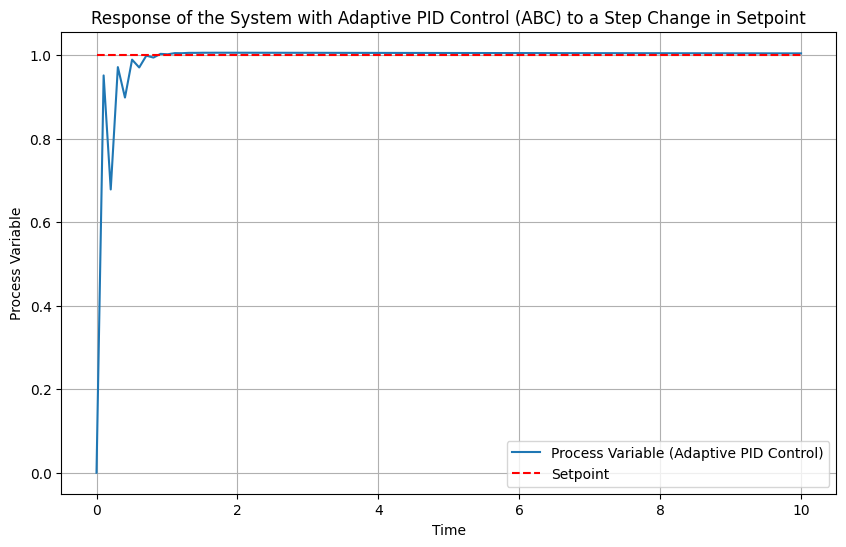

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulated system (a simple first-order system)
def model(y, K, dt):
    return y + dt * (-K * (y - 1))

# Artificial Bee Colony (ABC) Algorithm for adaptive tuning
class ABCAdaptiveController:
    def __init__(self, Kp_range, Ki_range, Kd_range):
        self.Kp_range = Kp_range
        self.Ki_range = Ki_range
        self.Kd_range = Kd_range
        self.best_solution = None
        self.best_error = float('inf')

    def generate_solution(self):
        Kp = np.random.uniform(*self.Kp_range)
        Ki = np.random.uniform(*self.Ki_range)
        Kd = np.random.uniform(*self.Kd_range)
        return [Kp, Ki, Kd]

    def evaluate_solution(self, solution, setpoint, initial_state, time):
        Kp, Ki, Kd = solution
        pid_controller = PIDController(Kp, Ki, Kd, time[1] - time[0])
        process_variable = simulate_system_with_pid_control(pid_controller, K, setpoint, initial_state, time)
        error = np.mean(np.abs(np.array(setpoint) - process_variable))
        return error

    def search(self, setpoint, initial_state, time, max_iterations=100):
        for _ in range(max_iterations):
            solution = self.generate_solution()
            error = self.evaluate_solution(solution, setpoint, initial_state, time)
            if error < self.best_error:
                self.best_solution = solution
                self.best_error = error
        return self.best_solution

# Function to simulate the system with PID control
def simulate_system_with_pid_control(controller, K, setpoint, initial_state, time):
    process_variable = np.zeros(len(time))
    process_variable[0] = initial_state
    for i in range(1, len(time)):
        control_output = controller.control(setpoint[i], process_variable[i-1])
        process_variable[i] = model(process_variable[i-1] + control_output, K, time[1] - time[0])
    return process_variable

# Simulation parameters
setpoint_initial = 1.0
initial_state = 0.0
time = np.linspace(0, 10, 100)

# System parameters
K = 0.5  # System gain

# PID tuning parameter ranges for ABC algorithm
Kp_range = [0.1, 2.0]
Ki_range = [0.01, 0.5]
Kd_range = [0.001, 0.1]

# Initialize ABC adaptive controller
abc_controller = ABCAdaptiveController(Kp_range, Ki_range, Kd_range)

# Search for optimal PID parameters using ABC algorithm
best_solution = abc_controller.search([setpoint_initial] * len(time), initial_state, time)

# Simulate system with optimal PID controller
pid_controller = PIDController(*best_solution, time[1] - time[0])
process_variable_abc = simulate_system_with_pid_control(pid_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, process_variable_abc, label='Process Variable (Adaptive PID Control)')
plt.plot(time, [setpoint_initial] * len(time), 'r--', label='Setpoint')
plt.title('Response of the System with Adaptive PID Control (ABC) to a Step Change in Setpoint')
plt.xlabel('Time')
plt.ylabel('Process Variable')
plt.legend()
plt.grid(True)
plt.show()


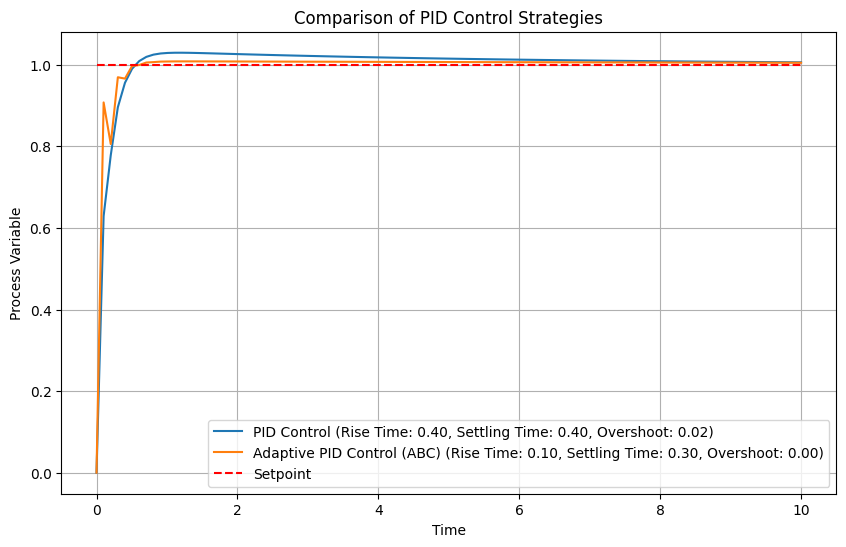

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Simulated system (a simple first-order system)
def model(y, K, dt):
    return y + dt * (-K * (y - 1))

# PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.prev_error = 0
        self.integral = 0

    def control(self, setpoint, process_variable):
        error = setpoint - process_variable
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        control_output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return control_output

# Artificial Bee Colony (ABC) Algorithm for adaptive tuning
class ABCAdaptiveController:
    def __init__(self, Kp_range, Ki_range, Kd_range):
        self.Kp_range = Kp_range
        self.Ki_range = Ki_range
        self.Kd_range = Kd_range
        self.best_solution = None
        self.best_error = float('inf')

    def generate_solution(self):
        Kp = np.random.uniform(*self.Kp_range)
        Ki = np.random.uniform(*self.Ki_range)
        Kd = np.random.uniform(*self.Kd_range)
        return [Kp, Ki, Kd]

    def evaluate_solution(self, solution, setpoint, initial_state, time):
        Kp, Ki, Kd = solution
        pid_controller = PIDController(Kp, Ki, Kd, time[1] - time[0])
        process_variable = simulate_system_with_pid_control(pid_controller, K, setpoint, initial_state, time)
        error = np.mean(np.abs(np.array(setpoint) - process_variable))
        return error

    def search(self, setpoint, initial_state, time, max_iterations=100):
        for _ in range(max_iterations):
            solution = self.generate_solution()
            error = self.evaluate_solution(solution, setpoint, initial_state, time)
            if error < self.best_error:
                self.best_solution = solution
                self.best_error = error
        return self.best_solution

# Function to simulate the system with PID control
def simulate_system_with_pid_control(controller, K, setpoint, initial_state, time):
    process_variable = np.zeros(len(time))
    process_variable[0] = initial_state
    for i in range(1, len(time)):
        control_output = controller.control(setpoint[i], process_variable[i-1])
        process_variable[i] = model(process_variable[i-1] + control_output, K, time[1] - time[0])
    return process_variable

# Function to simulate the system with ABC adaptive control
def simulate_system_with_abc_adaptive_control(controller, K, setpoint, initial_state, time):
    best_solution = controller.search(setpoint, initial_state, time)
    Kp, Ki, Kd = best_solution
    pid_controller = PIDController(Kp, Ki, Kd, time[1] - time[0])
    process_variable = simulate_system_with_pid_control(pid_controller, K, setpoint, initial_state, time)
    return process_variable

# Function to calculate rise time, settling time, and overshoot
def calculate_performance_metrics(time, process_variable):
    # Rise time: Time taken to reach 90% of the final value for the first time
    rise_time = next(i * (time[1] - time[0]) for i, pv in enumerate(process_variable) if pv >= 0.9 * process_variable[-1])

    # Settling time: Time taken for the process variable to stay within +/-5% of the final value
    settling_time = next(i * (time[1] - time[0]) for i, pv in enumerate(process_variable) if abs(pv - process_variable[-1]) <= 0.05 * abs(process_variable[-1]))

    # Overshoot: Maximum overshoot of the process variable from the setpoint
    overshoot = max(process_variable) - process_variable[-1]

    return rise_time, settling_time, overshoot

# Simulation parameters
setpoint_initial = 1.0
initial_state = 0.0
time = np.linspace(0, 10, 100)

# System parameters
K = 0.5  # System gain

# PID tuning parameter ranges for ABC algorithm
Kp_range = [0.1, 2.0]
Ki_range = [0.01, 0.5]
Kd_range = [0.001, 0.1]

# Initialize controllers
pid_controller = PIDController(0.5, 0.1, 0.01, time[1] - time[0])
abc_controller = ABCAdaptiveController(Kp_range, Ki_range, Kd_range)

# Simulate system with PID control
process_variable_pid = simulate_system_with_pid_control(pid_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Simulate system with ABC adaptive control
process_variable_abc = simulate_system_with_abc_adaptive_control(abc_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Calculate performance metrics for PID control
rise_time_pid, settling_time_pid, overshoot_pid = calculate_performance_metrics(time, process_variable_pid)

# Calculate performance metrics for ABC adaptive control
rise_time_abc, settling_time_abc, overshoot_abc = calculate_performance_metrics(time, process_variable_abc)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, process_variable_pid, label=f'PID Control (Rise Time: {rise_time_pid:.2f}, Settling Time: {settling_time_pid:.2f}, Overshoot: {overshoot_pid:.2f})')
plt.plot(time, process_variable_abc, label=f'Adaptive PID Control (ABC) (Rise Time: {rise_time_abc:.2f}, Settling Time: {settling_time_abc:.2f}, Overshoot: {overshoot_abc:.2f})')
plt.plot(time, [setpoint_initial] * len(time), 'r--', label='Setpoint')
plt.title('Comparison of PID Control Strategies')
plt.xlabel('Time')
plt.ylabel('Process Variable')
plt.legend()
plt.grid(True)
plt.show()


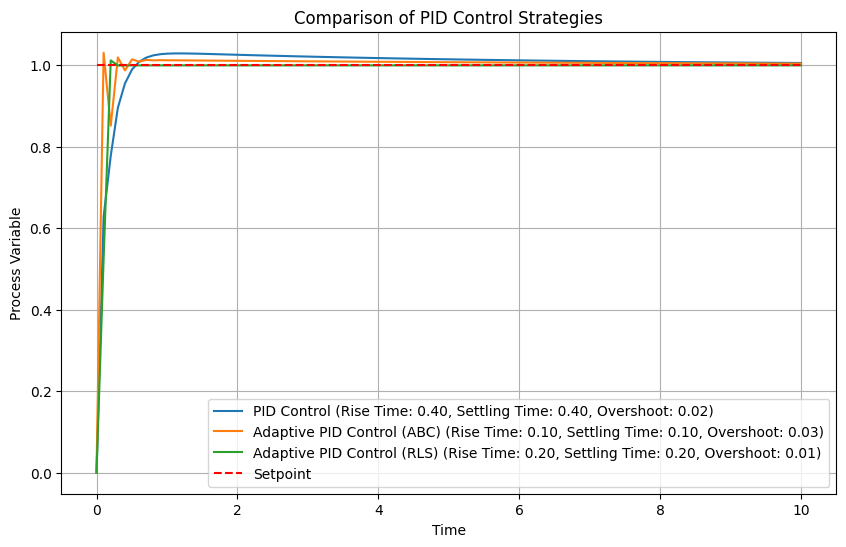

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated system (a simple first-order system)
def model(y, K, dt):
    return y + dt * (-K * (y - 1))

# PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.prev_error = 0
        self.integral = 0

    def control(self, setpoint, process_variable):
        error = setpoint - process_variable
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        control_output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return control_output

# Artificial Bee Colony (ABC) Algorithm for adaptive tuning
class ABCAdaptiveController:
    def __init__(self, Kp_range, Ki_range, Kd_range):
        self.Kp_range = Kp_range
        self.Ki_range = Ki_range
        self.Kd_range = Kd_range
        self.best_solution = None
        self.best_error = float('inf')

    def generate_solution(self):
        Kp = np.random.uniform(*self.Kp_range)
        Ki = np.random.uniform(*self.Ki_range)
        Kd = np.random.uniform(*self.Kd_range)
        return [Kp, Ki, Kd]

    def evaluate_solution(self, solution, setpoint, initial_state, time):
        Kp, Ki, Kd = solution
        pid_controller = PIDController(Kp, Ki, Kd, time[1] - time[0])
        process_variable = simulate_system_with_pid_control(pid_controller, K, setpoint, initial_state, time)
        error = np.mean(np.abs(np.array(setpoint) - process_variable))
        return error

    def search(self, setpoint, initial_state, time, max_iterations=100):
        for _ in range(max_iterations):
            solution = self.generate_solution()
            error = self.evaluate_solution(solution, setpoint, initial_state, time)
            if error < self.best_error:
                self.best_solution = solution
                self.best_error = error
        return self.best_solution

# Recursive Least Squares (RLS) Adaptive Tuning for PID Controller
class RLSAdaptiveController:
    def __init__(self, dt):
        self.dt = dt
        self.P = np.diag([1.0, 1.0, 1.0])
        self.theta = np.zeros((3, 1))

    def control(self, setpoint, process_variable):
        error = setpoint - process_variable
        phi = np.array([error, 0, 0]).reshape((3, 1))
        K = np.dot(self.P, phi) / (1 + np.dot(np.dot(phi.T, self.P), phi))
        self.theta += np.dot(K, error)
        self.P = (self.P - np.dot(np.dot(K, phi.T), self.P)) / self.dt
        Kp, Ki, Kd = self.theta.ravel()
        control_output = Kp * error + Ki * np.sum(error) * self.dt + Kd * error / self.dt
        return control_output

# Function to simulate the system with PID control
def simulate_system_with_pid_control(controller, K, setpoint, initial_state, time):
    process_variable = np.zeros(len(time))
    process_variable[0] = initial_state
    for i in range(1, len(time)):
        control_output = controller.control(setpoint[i], process_variable[i-1])
        process_variable[i] = model(process_variable[i-1] + control_output, K, time[1] - time[0])
    return process_variable

# Function to simulate the system with ABC adaptive control
def simulate_system_with_abc_adaptive_control(controller, K, setpoint, initial_state, time):
    best_solution = controller.search(setpoint, initial_state, time)
    Kp, Ki, Kd = best_solution
    pid_controller = PIDController(Kp, Ki, Kd, time[1] - time[0])
    process_variable = simulate_system_with_pid_control(pid_controller, K, setpoint, initial_state, time)
    return process_variable

# Function to simulate the system with RLS adaptive control
def simulate_system_with_rls_adaptive_control(controller, K, setpoint, initial_state, time):
    process_variable = np.zeros(len(time))
    process_variable[0] = initial_state
    for i in range(1, len(time)):
        control_output = controller.control(setpoint[i], process_variable[i-1])
        process_variable[i] = model(process_variable[i-1] + control_output, K, time[1] - time[0])
    return process_variable

# Function to calculate rise time, settling time, and overshoot
def calculate_performance_metrics(time, process_variable):
    # Rise time: Time taken to reach 90% of the final value for the first time
    rise_time = next(i * (time[1] - time[0]) for i, pv in enumerate(process_variable) if pv >= 0.9 * process_variable[-1])

    # Settling time: Time taken for the process variable to stay within +/-5% of the final value
    settling_time = next(i * (time[1] - time[0]) for i, pv in enumerate(process_variable) if abs(pv - process_variable[-1]) <= 0.05 * abs(process_variable[-1]))

    # Overshoot: Maximum overshoot of the process variable from the setpoint
    overshoot = max(process_variable) - process_variable[-1]

    return rise_time, settling_time, overshoot

# Simulation parameters
setpoint_initial = 1.0
initial_state = 0.0
time = np.linspace(0, 10, 100)

# System parameters
K = 0.5  # System gain

# PID tuning parameter ranges for ABC algorithm
Kp_range = [0.1, 2.0]
Ki_range = [0.01, 0.5]
Kd_range = [0.001, 0.1]

# Initialize controllers
pid_controller = PIDController(0.5, 0.1, 0.01, time[1] - time[0])
abc_controller = ABCAdaptiveController(Kp_range, Ki_range, Kd_range)
rls_controller = RLSAdaptiveController(time[1] - time[0])

# Simulate system with PID control
process_variable_pid = simulate_system_with_pid_control(pid_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Simulate system with ABC adaptive control
process_variable_abc = simulate_system_with_abc_adaptive_control(abc_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Simulate system with RLS adaptive control
process_variable_rls = simulate_system_with_rls_adaptive_control(rls_controller, K, [setpoint_initial] * len(time), initial_state, time)

# Calculate performance metrics for PID control
rise_time_pid, settling_time_pid, overshoot_pid = calculate_performance_metrics(time, process_variable_pid)

# Calculate performance metrics for ABC adaptive control
rise_time_abc, settling_time_abc, overshoot_abc = calculate_performance_metrics(time, process_variable_abc)

# Calculate performance metrics for RLS adaptive control
rise_time_rls, settling_time_rls, overshoot_rls = calculate_performance_metrics(time, process_variable_rls)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time, process_variable_pid, label=f'PID Control (Rise Time: {rise_time_pid:.2f}, Settling Time: {settling_time_pid:.2f}, Overshoot: {overshoot_pid:.2f})')
plt.plot(time, process_variable_abc, label=f'Adaptive PID Control (ABC) (Rise Time: {rise_time_abc:.2f}, Settling Time: {settling_time_abc:.2f}, Overshoot: {overshoot_abc:.2f})')
plt.plot(time, process_variable_rls, label=f'Adaptive PID Control (RLS) (Rise Time: {rise_time_rls:.2f}, Settling Time: {settling_time_rls:.2f}, Overshoot: {overshoot_rls:.2f})')
plt.plot(time, [setpoint_initial] * len(time), 'r--', label='Setpoint')
plt.title('Comparison of PID Control Strategies')
plt.xlabel('Time')
plt.ylabel('Process Variable')
plt.legend()
plt.grid(True)
plt.show()
